##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr)
library(RColorBrewer)
library(stats)
library(dplyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Use suppressPackageStartupMessages to eliminate package startup messages.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserW

##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

In [4]:
%%R 
physeq = import_biom("data/otu_table_wtax.biom")
print(physeq)
sample.data = import_qiime_sample_data("data/Metadata_fungi.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.fungi = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS")), physeq)
print(physeq.fungi)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 172 samples ]
sample_data() Sample Data:       [ 172 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]


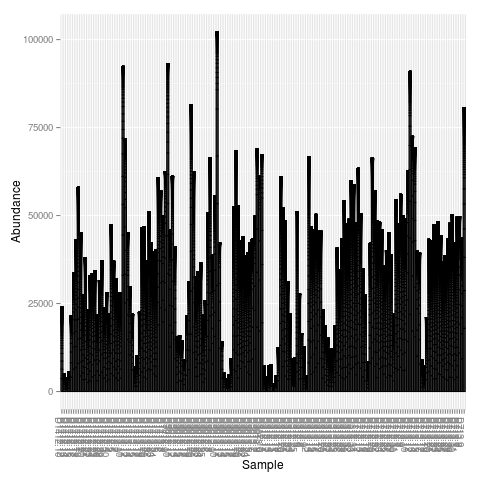

In [5]:
%%R
plot_bar(physeq.fungi)

In [6]:
%%R
sums.physeq = sample_sums(physeq.fungi)
sums.quantile = quantile(sums.physeq,  probs = c(0.1, 0.5, 1, 2, 5, 10, 50, NA)/100)
print(sums.quantile)
sums.physeq.filter = subset(sums.physeq, sum = 5360 )
head(sums.physeq)

     0.1%      0.5%        1%        2%        5%       10%       50%           
 2491.084  3451.420  3771.440  4326.120  5360.050  8948.600 40899.000        NA 
Error in subset.default(sums.physeq, sum = 5360) : 
  argument "subset" is missing, with no default
In addition: Warning message:
position_stack requires constant width: output may be incorrect
Error in subset.default(sums.physeq, sum = 5360) : 
  argument "subset" is missing, with no default


In [7]:
%%R
class(sums.physeq)
head(sums.physeq)

D1412.18  D713.15  D712.18  D3012.7 D3013.20   D712.9 
   58017    39317    42067    66408    42760    48953 


In [6]:
%%R
physeq = import_biom("data/otu_table_wtax.biom")
print(physeq)
sample.data = import_qiime_sample_data("data/Metadata_fungi.txt")
physeq = merge_phyloseq(physeq,sample.data)
print(physeq)
physeq.md = sample_data(physeq)
physeq.fungi = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))& 
                             (physeq.md$SampleID != c("D312.6")),  physeq)
physeq.fungi.prune = prune_samples(sample_sums(physeq.fungi) > 5360, physeq.fungi)
print (physeq.fungi.prune)
physeq.fungi.snorm = transform_sample_counts(physeq.fungi.prune, function(x) x/sum(x))
physeq.fungi.thresh = filter_taxa(physeq.fungi.snorm, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
#physeq.fungi.thresh.min = filter_taxa(physeq.fungi.thresh, function(x) sum(x) > 5000, TRUE)
#physeq.fungi.thresh = filter_taxa(physeq.SIP.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.fungi.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 600 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 600 taxa by 7 taxonomic ranks ]


In [7]:
%%R
head(physeq.md)

Sample Data:        [6 samples by 9 sample variables]:
         SampleID Primers       i2       i1 Day  Density Treatment Mock_Comm
D1412.18 D1412.18      14 cgtgagtg gacatagt  14 1.693620    12CCPS         N
D713.15   D713.15     135 ggatatct gatctacg   7 1.720939    13CCPS         N
D712.18   D712.18     114 actatctg tagcagct   7 1.708918    12CCPS         N
D3012.7   D3012.7      67 tagcgagt actacgac  30 1.752629    12CCPS         N
D3013.20 D3013.20     101 tcatcgag ctcgactt  30 1.692527    13CCPS         N
D712.9     D712.9     108 ctgcgtgt cgaagtat   7 1.742794    12CCPS         N
         RNA_DNA
D1412.18     DNA
D713.15      DNA
D712.18      DNA
D3012.7      DNA
D3013.20     DNA
D712.9       DNA


In [42]:
%%R
df = psmelt(physeq.fungi.prune)

In [46]:
%%R
head(df)

         OTU   Sample Abundance SampleID Primers       i2       i1 Day  Density
159    OTU.1  D1413.9     33528  D1413.9      30 cgtgagtg actcactg  14 1.735145
143    OTU.1 D1413.10     33074 D1413.10      31 ggatatct actcactg  14 1.729681
101495 OTU.2 D3013.10     30125 D3013.10      91 tagcgagt tatagcga  30 1.731866
88     OTU.1 D1413.11     25235 D1413.11      32 gacaccgt actcactg  14 1.725310
90     OTU.1  D1413.6     23819  D1413.6      27 tagcgagt actcactg  14 1.751536
53     OTU.1 D3013.10     23256 D3013.10      91 tagcgagt tatagcga  30 1.731866
       Treatment Mock_Comm RNA_DNA    Rank1         Rank2              Rank3
159       13CCPS         N     DNA k__Fungi          <NA>               <NA>
143       13CCPS         N     DNA k__Fungi          <NA>               <NA>
101495    13CCPS         N     DNA k__Fungi p__Ascomycota c__Sordariomycetes
88        13CCPS         N     DNA k__Fungi          <NA>               <NA>
90        13CCPS         N     DNA k__Fungi          <N

In [96]:
%%R
a = df %>%
group_by(Sample) %>%
select(Sample, Abundance) 
a

Source: local data frame [329,184 x 2]
Groups: Sample [162]

     Sample Abundance
      (chr)     (dbl)
1   D1413.9     33528
2  D1413.10     33074
3  D3013.10     30125
4  D1413.11     25235
5   D1413.6     23819
6  D3013.10     23256
7   D1413.8     23248
8   D713.11     21896
9   D713.11     21733
10  D1413.7     19850
..      ...       ...


In [97]:
%%R
a %>%
summarise(tab = sum(Abundance)) %>%
summarise(avg = mean(tab), std = sd(tab))

Source: local data frame [1 x 2]

       avg      std
     (dbl)    (dbl)
1 40587.69 19098.87


In [98]:
%%R
a$Gradient = sub("^(.*)[.].*", "\\1", a$Sample)


In [99]:
%%R
a %>% group_by(Gradient) %>% 
select(Gradient, Abundance) %>%
summarise(totab = sum(Abundance))# %>%
#summarise(avg = mean(totab), std = sd(totab))

Source: local data frame [8 x 2]

  Gradient   totab
     (chr)   (dbl)
1    D1412  756635
2    D1413  926907
3    D3012  761232
4    D3013  838304
5     D312  359201
6     D313  836149
7     D712  930899
8     D713 1165879


In [100]:
%%R
a %>% group_by(Gradient) %>% 
select(Gradient) %>%
summarise(sumsample = n())# %>%
#summarise(avg = mean(totab), std = sd(totab))

Source: local data frame [8 x 2]

  Gradient sumsample
     (chr)     (int)
1    D1412     48768
2    D1413     40640
3    D3012     40640
4    D3013     34544
5     D312     28448
6     D313     42672
7     D712     42672
8     D713     50800


### Calculate Bray-Curtis distances between samples.

In [7]:
%%R
iDist <- distance(physeq.fungi.thresh, method = "bray")

### Plotting Bray-Curtis distance vs. density

In [10]:
%%R
p = ggplot()

###Ordinate using weighted unifrac distnaces with NMDS.

Run 0 stress 0.09429138 
Run 1 stress 0.104423 
Run 2 stress 0.1041976 
Run 3 stress 0.09428955 
... New best solution
... procrustes: rmse 0.0001445469  max resid 0.001264798 
*** Solution reached
TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


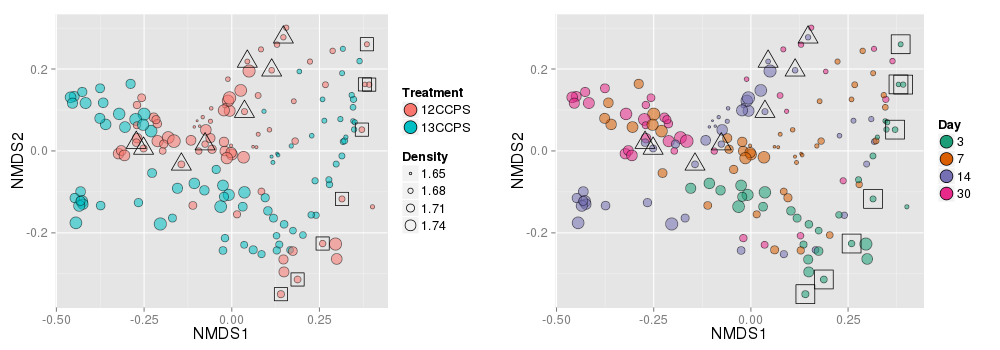

In [15]:
%%R -w 1000 -h 350
nmds = ordinate(physeq.fungi.thresh, 
                method = "NMDS", 
                distance = iDist)
p.nmds = plot_ordination(physeq.fungi.thresh, nmds, justDF = TRUE)
#print(p)

asNumeric = function(x) { as.numeric(as.character(x)) }

sub = p.nmds %>% filter(Primers%in% c(57,58,59,60,61,62,63,64))
sub2 = p.nmds %>% filter(Primers%in% c(11,12,13,14,15,16,17,18))

p1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 
p1 = p1 + geom_point(data = sub, aes(x= NMDS1, y = NMDS2), shape = 22, size = 7 ) 
p1 = p1 + geom_point(data = sub2, aes(x= NMDS1, y = NMDS2), shape = 24, size = 7 ) 


      

p2 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        scale_fill_brewer("Day", palette = "Dark2") + theme(text = element_text(size=16)) 
p2 = p2 + geom_point(data = sub, aes(x= NMDS1, y = NMDS2), shape = 22, size = 10 ) 
p2 = p2 + geom_point(data = sub2, aes(x= NMDS1, y = NMDS2), shape = 24, size = 7 ) 



p.combined = grid.arrange(p1, p2, ncol=2)
print(p.combined)

In [14]:
%%R -w 1000 -h 350
pdf("figs/full_ordination.pdf", width = 12, height = 5)
grid.arrange(p1, p2, ncol=2)
dev.off()

Error in pdf("figs/full_ordination.pdf", width = 12, height = 5) : 
  cannot open file 'figs/full_ordination.pdf'


In [15]:
FileLink("figs/full_ordination.pdf")

/home/chantal/FungalSIP/figs/full_ordination.pdf

###...and the MDS figure (PC2 v Density).

NULL


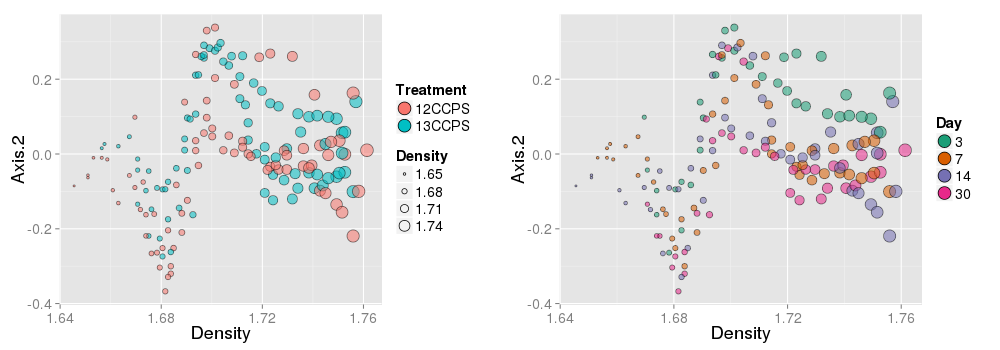

In [9]:
%%R -w 1000 -h 350
mds = ordinate(physeq.fungi.thresh, 
                method = "MDS", 
                distance = iDist)
p.mds = plot_ordination(physeq.fungi.thresh, mds, justDF = TRUE)

asNumeric = function(x) { as.numeric(as.character(x)) }

p1.mds = ggplot(p.mds, aes(x = asNumeric(Density), y = Axis.2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(x = "Density", size = "Density")+
        theme(text = element_text(size=18)) 

p2.mds = ggplot(p.mds, aes(x = asNumeric(Density), y = Axis.2)) + labs(x = "Density") +
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+ 
        scale_fill_brewer("Day", palette = "Dark2") + theme(text = element_text(size=18)) 

p.combined.mds = grid.arrange(p1.mds, p2.mds, ncol=2)
print(p.combined.mds)

In [17]:
%%R -w 1000 -h 350
pdf("figs/full_ordination_density.pdf", width = 12, height = 5)
grid.arrange(p1.mds, p2.mds, ncol=2)
dev.off()

Error in pdf("figs/full_ordination_density.pdf", width = 12, height = 5) : 
  cannot open file 'figs/full_ordination_density.pdf'


In [18]:
FileLink("figs/full_ordination_density.pdf")

/home/chantal/FungalSIP/figs/full_ordination_density.pdf

# Checking different distance matrices

In [34]:
%%R
dist_methods = unlist(distance("list"))
dist_methods = dist_methods[-(1:2)]
dist_methods = dist_methods[-which(dist_methods == "ANY")]
dist_methods = dist_methods[-which(dist_methods == "morisita")]
dist_methods = dist_methods[-which(dist_methods == "mountford")]
dist_methods = dist_methods[-which(dist_methods == "dpcoa")]
print(dist_methods)

         JSD     vegdist1     vegdist2     vegdist3     vegdist4     vegdist5 
       "jsd"  "manhattan"  "euclidean"   "canberra"       "bray" "kulczynski" 
    vegdist6     vegdist7     vegdist8    vegdist10    vegdist12    vegdist13 
   "jaccard"      "gower"   "altGower"       "horn"       "raup"   "binomial" 
   vegdist14    vegdist15   betadiver1   betadiver2   betadiver3   betadiver4 
      "chao"        "cao"          "w"         "-1"          "c"         "wb" 
  betadiver5   betadiver6   betadiver7   betadiver8   betadiver9  betadiver10 
         "r"          "I"          "e"          "t"         "me"          "j" 
 betadiver11  betadiver12  betadiver13  betadiver14  betadiver15  betadiver16 
       "sor"          "m"         "-2"         "co"         "cc"          "g" 
 betadiver17  betadiver18  betadiver19  betadiver20  betadiver21  betadiver22 
        "-3"          "l"         "19"         "hk"        "rlb"        "sim" 
 betadiver23  betadiver24        dist1        dist2 

In [35]:
%%R
plist <- vector("list", length(dist_methods))
names(plist) = dist_methods
for (i in dist_methods) {
    print(i) #for debugging
    # Calculate distance matrix
        iDist <- distance(physeq.fungi.thresh, method = i)
    # Calculate ordination
    iMDS <- ordinate(physeq.fungi.thresh, "MDS", distance = iDist)
    ## Make plot Don't carry over previous plot (if error, p will be blank)
    p <- NULL
    # Create plot, store as temp variable, p
    p <- plot_ordination(physeq.fungi.thresh, iMDS, color = "treatment")
    # Add title to each plot
    p <- p + ggtitle(paste("MDS using distance method ", i, sep = ""))
    plist[[i]] = p
}

[1] "jsd"
[1] "manhattan"
[1] "euclidean"
[1] "canberra"
[1] "bray"
[1] "kulczynski"
[1] "jaccard"
[1] "gower"
[1] "altGower"
[1] "horn"
[1] "raup"
[1] "binomial"
[1] "chao"
[1] "cao"
[1] "w"
[1] "-1"
[1] "c"
[1] "wb"
[1] "r"
[1] "I"
[1] "e"
[1] "t"
[1] "me"
[1] "j"
[1] "sor"
[1] "m"
[1] "-2"
[1] "co"
[1] "cc"
[1] "g"
[1] "-3"
[1] "l"
[1] "19"
[1] "hk"
[1] "rlb"
[1] "sim"
[1] "gl"
[1] "z"
[1] "maximum"
[1] "binary"
[1] "minkowski"


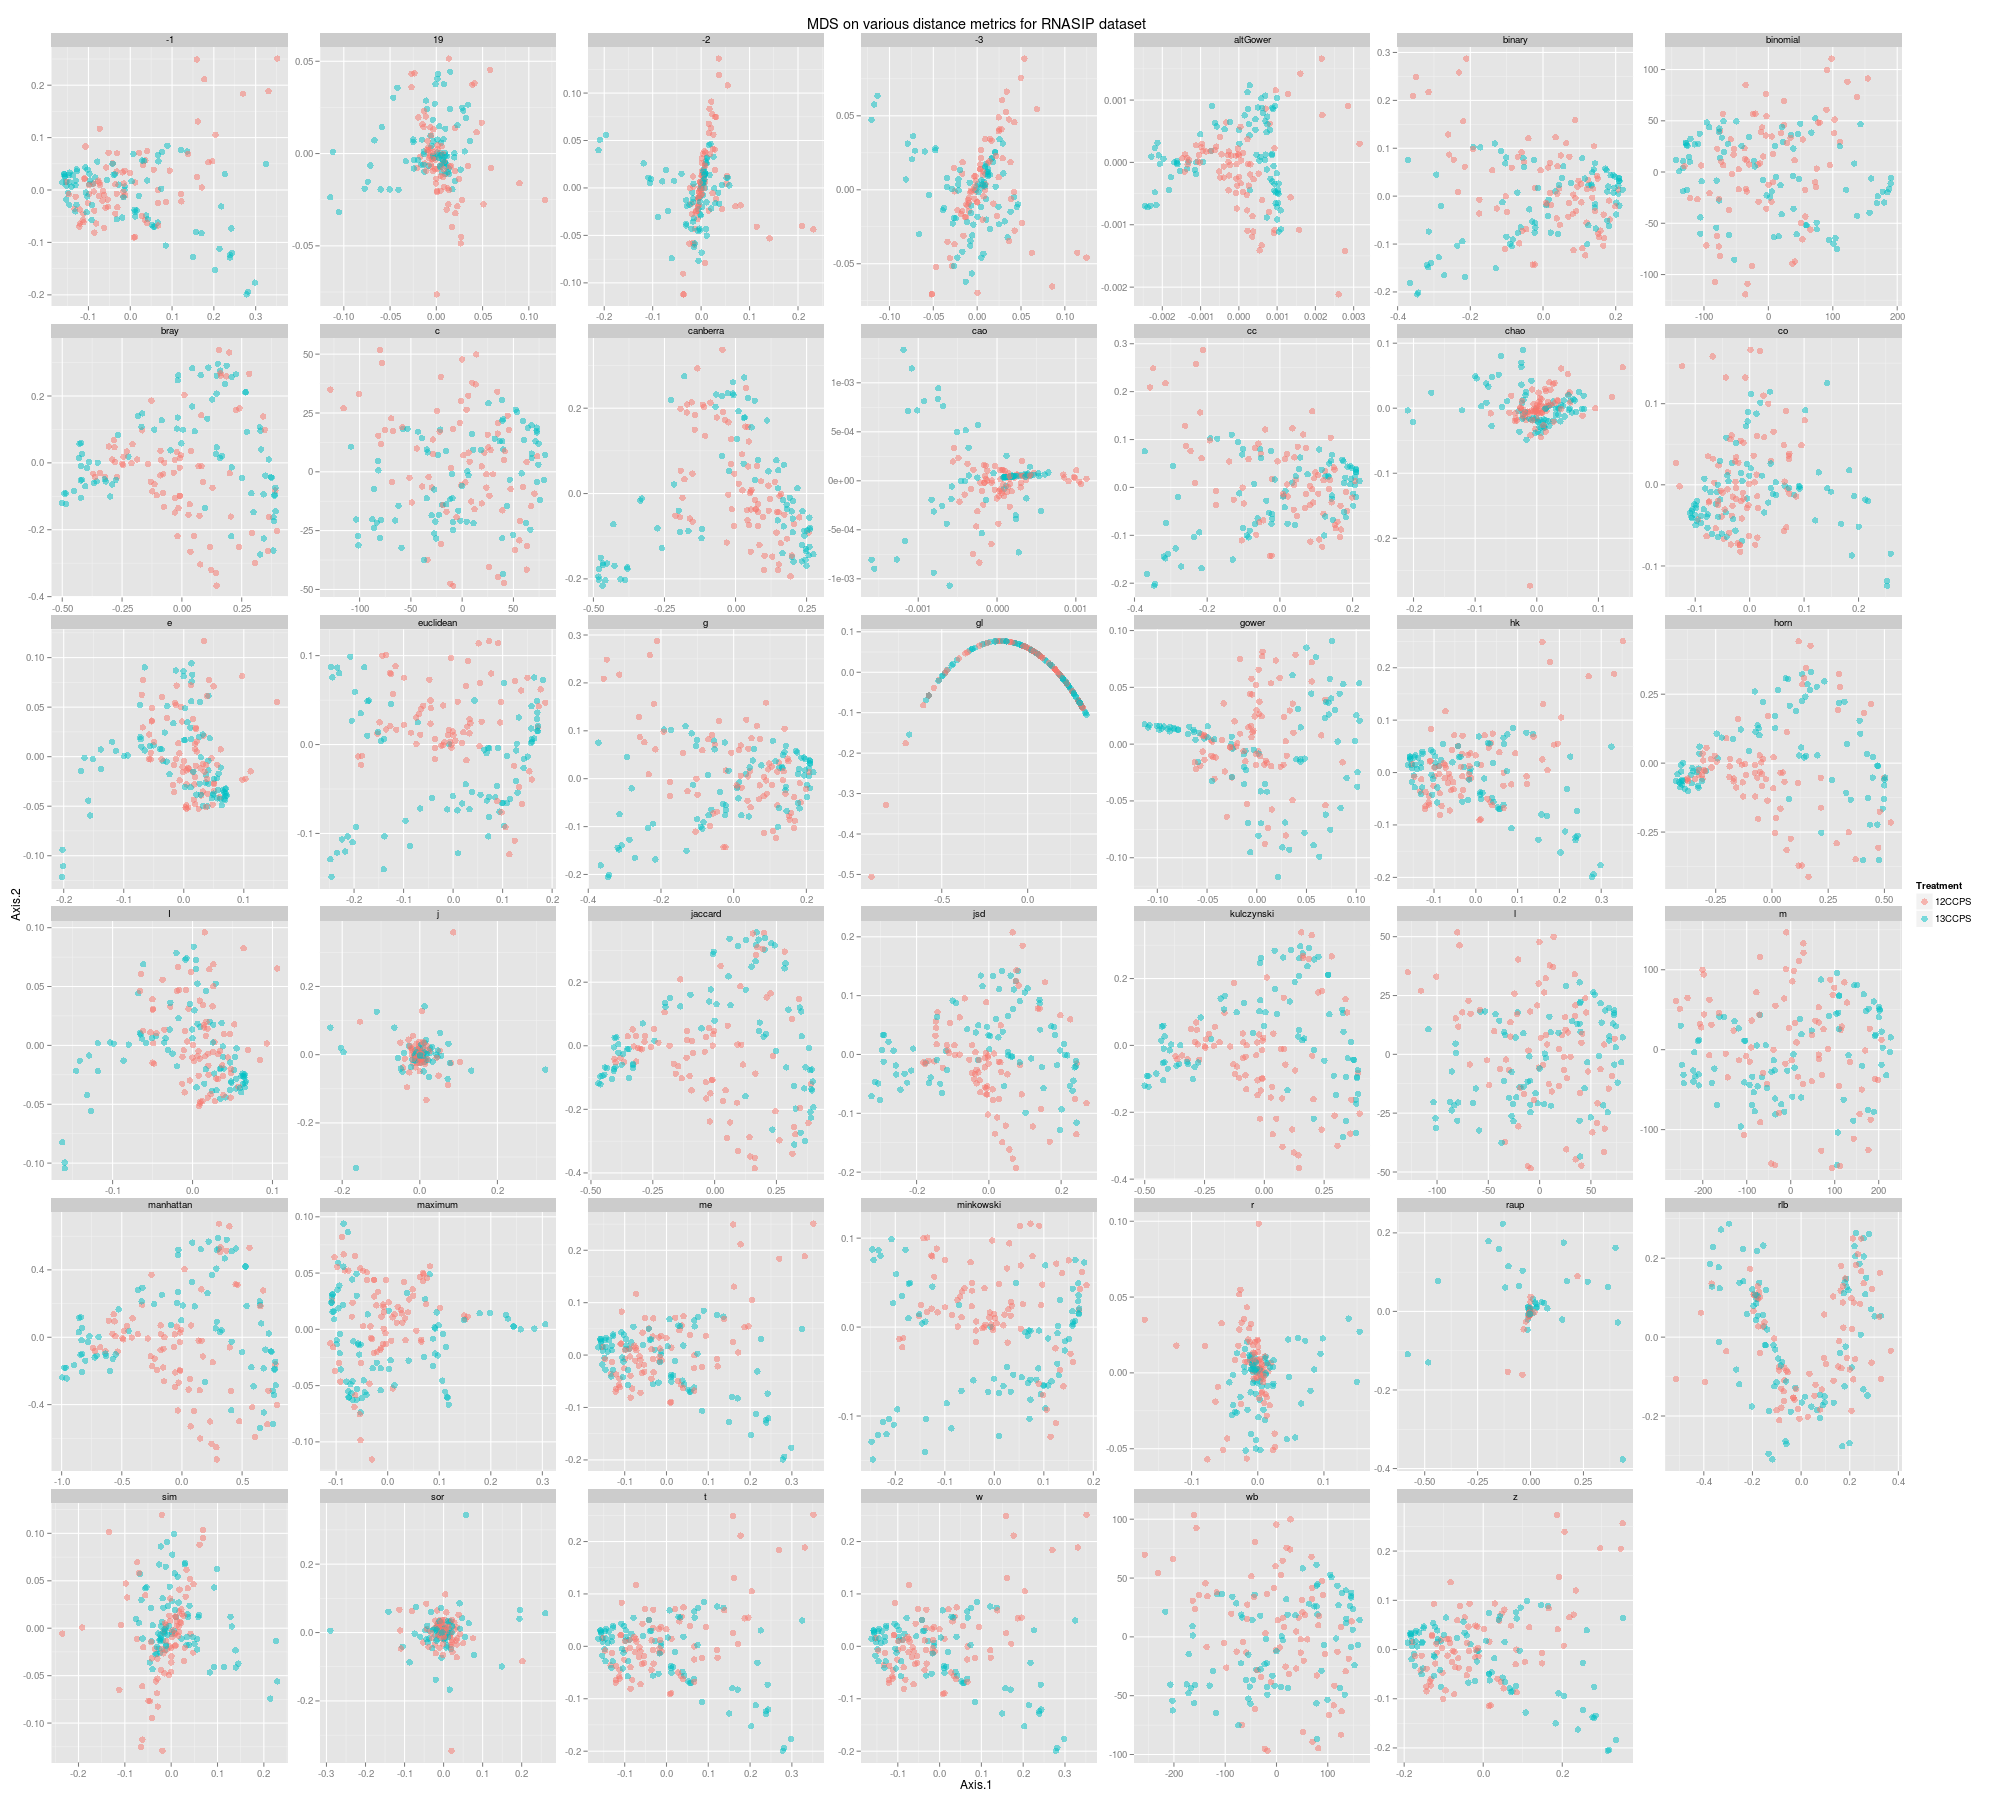

In [36]:
%%R -h 1800 -w 2000
df = ldply(plist, function(x) x$data)
names(df)[1] <- "distance"
p = ggplot(df, aes(Axis.1, Axis.2, color = Treatment))
p = p + geom_point(size = 3, alpha = 0.5)
p = p + facet_wrap(~distance, scales = "free")
p = p + ggtitle("MDS on various distance metrics for RNASIP dataset")
p_facet_dist = p
print(p)

In [22]:
FileLink("figs/dragonfly_inset_facet_grid.pdf")

/home/chantal/FungalSIP/figs/dragonfly_inset_facet_grid.pdf

NULL


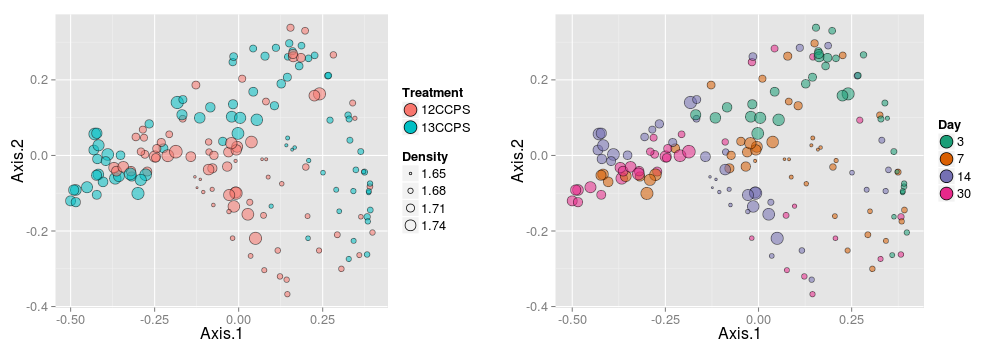

In [15]:
%%R -w 1000 -h 350
pcoa = ordinate(physeq.fungi.thresh, 
                method = "PCoA", 
                distance = "bray")
p.pcoa = plot_ordination(physeq.fungi.thresh, pcoa, justDF = TRUE)
#print(p.pcoa)

asNumeric = function(x) { as.numeric(as.character(x)) }

p1 = ggplot(p.pcoa, aes(x = Axis.1, y = Axis.2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 

p2 = ggplot(p.pcoa, aes(x = Axis.1, y = Axis.2)) +  
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+ 
        scale_fill_brewer("Day", palette = "Dark2") + theme(text = element_text(size=16)) 

p.combined = grid.arrange(p1, p2, ncol=2)
print(p.combined)


In [11]:
%%R
registerDoParallel(cores=20)

md = sample_data(physeq.fungi.thresh)
days = unique(md$Day)
days = days[order(days)]

species.scores = function(x, y) {
    # x is the site scores data frame
    # y is the corresponding phyloseq object
    
    site.scores = x[,c(1,2)]
    
    if( setequal(row.names(site.scores), row.names(t(otu_table(y)))) ){
        w = wascores(site.scores,t(otu_table(y)),expand=TRUE)
    } else {
        print("Indices don't match")
        print(setdiff(row.names(site.scores), row.names(t(otu_table(y)))))
    }                                    

    otu.scores = data.frame(w)
    otu.scores$OTU = rownames(otu.scores)
    
    supp = tax_table(y)
    
    if( setequal(row.names(otu.scores), row.names(supp)) ){
        otu.scores.wtax = data.frame(otu.scores, supp)
    } else {
        print("Indices not the same.")
        print(setdiff(row.names(w), row.names(supp)))
    }
    
    return(otu.scores.wtax)
    
}

ord = function(x) {
    
    ps = prune_samples(md$Day == x, physeq.fungi.thresh)
    
    pcoa = ordinate(ps, 
                method = "PCoA", 
                distance = "bray")
    
    df.sites = plot_ordination(ps, pcoa, justDF = TRUE)
    df.sites$type = "sites"
    
    df.otus = species.scores(df.sites, ps)
    df.otus$Day = x
    df.otus$type = "otus"
    
    df = rbind.fill(df.otus, df.sites)
    
    return(df)
}

df.plot = ldply(days, ord)

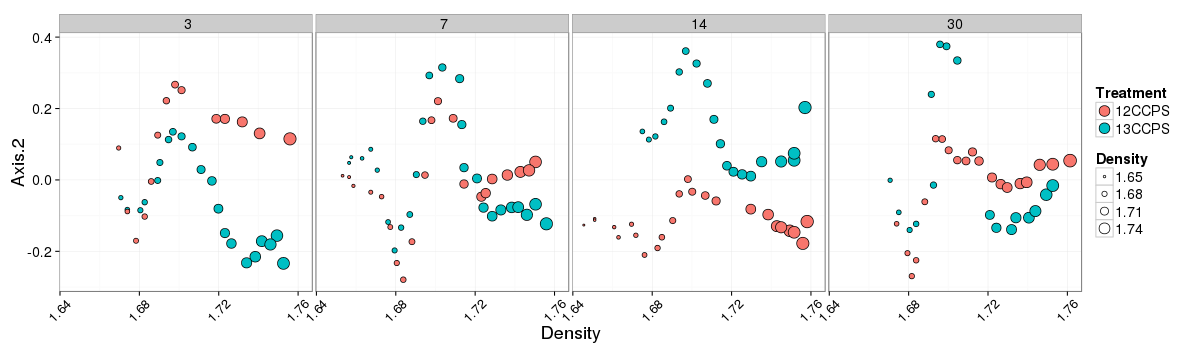

In [12]:
%%R -w 1200 -h 350

df = subset(df.plot, type == "sites")

asNum = function(x) as.numeric(as.character(x))

p = ggplot(df, aes(x =Density, y = Axis.2, size = Density, fill = Treatment))
#p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p = p + facet_wrap(~Day, nrow=1)

p = p + geom_point(shape = 21)

p = p + theme_bw() + theme(text = element_text(size=18), axis.text.x  = element_text(angle=45, vjust=0.5, size=13)) +
    guides(fill = guide_legend(override.aes = list(size=5)))
    
p

In [13]:
%%R
registerDoParallel(cores=20)

md = sample_data(physeq.fungi.thresh)
days = unique(md$Day)
days = days[order(days)]

species.scores = function(x, y) {
    # x is the site scores data frame
    # y is the corresponding phyloseq object
    
    site.scores = x[,c(1,2)]
    
    if( setequal(row.names(site.scores), row.names(t(otu_table(y)))) ){
        w = wascores(site.scores,t(otu_table(y)),expand=TRUE)
    } else {
        print("Indices don't match")
        print(setdiff(row.names(site.scores), row.names(t(otu_table(y)))))
    }                                    

    otu.scores = data.frame(w)
    otu.scores$OTU = rownames(otu.scores)
    
    supp = tax_table(y)
    
    if( setequal(row.names(otu.scores), row.names(supp)) ){
        otu.scores.wtax = data.frame(otu.scores, supp)
    } else {
        print("Indices not the same.")
        print(setdiff(row.names(w), row.names(supp)))
    }
    
    return(otu.scores.wtax)
    
}

ord = function(x) {
    
    ps = prune_samples(md$Day == x, physeq.fungi.thresh)
    
    pcoa = ordinate(ps, 
                method = "NMDS", 
                distance = "bray")
    
    df.sites = plot_ordination(ps, pcoa, justDF = TRUE)
    df.sites$type = "sites"
    
    df.otus = species.scores(df.sites, ps)
    df.otus$Day = x
    df.otus$type = "otus"
    
    df = rbind.fill(df.otus, df.sites)
    
    return(df)
}

df.plot = ldply(days, ord)

Run 0 stress 0.08883458 
Run 1 stress 0.1206639 
Run 2 stress 0.1131981 
Run 3 stress 0.1206639 
Run 4 stress 0.1204994 
Run 5 stress 0.10768 
Run 6 stress 0.1074605 
Run 7 stress 0.08889257 
... procrustes: rmse 0.00695767  max resid 0.03299468 
Run 8 stress 0.1204994 
Run 9 stress 0.08889257 
... procrustes: rmse 0.006958064  max resid 0.0330012 
Run 10 stress 0.1076898 
Run 11 stress 0.1073987 
Run 12 stress 0.1074605 
Run 13 stress 0.1074605 
Run 14 stress 0.1073987 
Run 15 stress 0.1076899 
Run 16 stress 0.2633896 
Run 17 stress 0.1076898 
Run 18 stress 0.1076898 
Run 19 stress 0.08883461 
... procrustes: rmse 3.978852e-05  max resid 0.0001972727 
*** Solution reached
Run 0 stress 0.06181737 
Run 1 stress 0.1310303 
Run 2 stress 0.1121001 
Run 3 stress 0.06040189 
... New best solution
... procrustes: rmse 0.01245879  max resid 0.05941381 
Run 4 stress 0.1220266 
Run 5 stress 0.06181734 
Run 6 stress 0.06040189 
... New best solution
... procrustes: rmse 1.968642e-05  max resid 4.

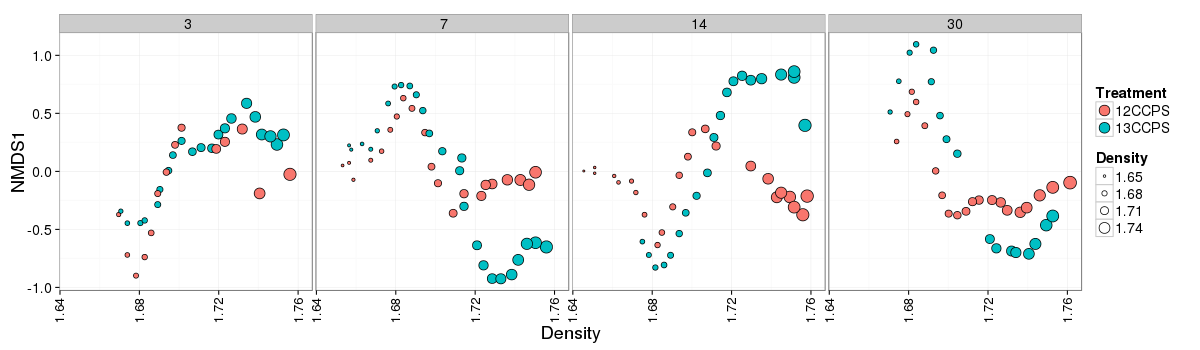

In [17]:
%%R -w 1200 -h 350

df = subset(df.plot, type == "sites")

asNum = function(x) as.numeric(as.character(x))

#p = ggplot(df, aes(x =Density, y = Axis.2, size = Density, fill = Treatment))
p = ggplot(df, aes(x = Density, y = NMDS1, size = Density, fill = Treatment))
    
#labeli <- function(variable, value){
 # names_li <- list(3 ="Day 3", 7="Day 7", 14="Day 14", 30="Day 30")
  #return(names_li[value])}

p = p + facet_wrap(~Day, nrow = 1)

p = p + geom_point(shape = 21)

p = p + theme_bw() + theme(text = element_text(size=18), axis.text.x  = element_text(angle=90, vjust=0.5, size=13)) +
    guides(fill = guide_legend(override.aes = list(size=5)))
   
p

In [44]:
%%R
ggsave("data/figs/NMDS_by_day_Density.pdf",p, width = 12, height = 5)

### Adonis Stats

In [36]:
%%R
physeq.data = as(sample_data(physeq.fungi.thresh), "data.frame")
physeq.heavy = prune_samples((physeq.data$Density >= 1.7125), physeq.fungi.thresh)
physeq.heavy.data = as(sample_data(physeq.heavy), "data.frame")
physeq.a = prune_samples(!is.na(physeq.data$Density), physeq.fungi.thresh)
physeq.new = as(sample_data(physeq.a), "data.frame")
physeq.Day3  = prune_samples((physeq.data$Density >= 1.7125) & (physeq.data$Day == 3), physeq.fungi.thresh)
physeq.Day7 = prune_samples((physeq.data$Density >= 1.7125) & (physeq.data$Day == 7), physeq.fungi.thresh)
physeq.Day14 = prune_samples((physeq.data$Density >= 1.7125) & (physeq.data$Day == 14), physeq.fungi.thresh)
physeq.Day30 = prune_samples((physeq.data$Density >= 1.7125) & (physeq.data$Day == 30), physeq.fungi.thresh)
physeq.3.data = as(sample_data(physeq.Day3), "data.frame")
physeq.7.data = as(sample_data(physeq.Day7), "data.frame")
physeq.14.data = as(sample_data(physeq.Day14), "data.frame")
physeq.30.data = as(sample_data(physeq.Day30), "data.frame")

In [37]:
%%R 
adonis(iDist ~ Treatment, physeq.data)


Call:
adonis(formula = iDist ~ Treatment, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)  
Treatment   1    0.4119 0.41189  3.3446 0.02048  0.025 *
Residuals 160   19.7039 0.12315         0.97952         
Total     161   20.1158                 1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [38]:
%%R 
adonis(iDist ~ Day, physeq.data)


Call:
adonis(formula = iDist ~ Day, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Day         1    2.5198 2.51980  22.913 0.12526  0.001 ***
Residuals 160   17.5960 0.10997         0.87474           
Total     161   20.1158                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [21]:
%%R
registerDoParallel(cores=20)
dist.heavy = distance(physeq.heavy, 
                      method = "bray",
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [23]:
%%R 
adonis(dist.heavy ~ Treatment, physeq.heavy.data)


Call:
adonis(formula = dist.heavy ~ Treatment, data = physeq.heavy.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model     R2 Pr(>F)    
Treatment  1    0.9114 0.91143  10.655 0.1372  0.001 ***
Residuals 67    5.7314 0.08554         0.8628           
Total     68    6.6429                 1.0000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [39]:
%%R 
adonis(dist.heavy ~ Day, physeq.heavy.data)


Call:
adonis(formula = dist.heavy ~ Day, data = physeq.heavy.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Day        1    1.5660 1.56598  20.666 0.23574  0.001 ***
Residuals 67    5.0769 0.07577         0.76426           
Total     68    6.6429                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [26]:
%%R
registerDoParallel(cores=20)
dist3 = distance(physeq.Day3, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
dist7 = distance(physeq.Day7, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
dist14 = distance(physeq.Day14, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
dist30 = distance(physeq.Day30, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [27]:
%%R 
adonis(dist3 ~ Treatment, physeq.3.data)


Call:
adonis(formula = dist3 ~ Treatment, data = physeq.3.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Treatment  1   0.42747 0.42747  11.362 0.46639  0.001 ***
Residuals 13   0.48908 0.03762         0.53361           
Total     14   0.91656                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [29]:
%%R 
adonis(dist7 ~ Treatment, physeq.7.data)


Call:
adonis(formula = dist7 ~ Treatment, data = physeq.7.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Treatment  1   0.46628 0.46628  14.306 0.45698  0.001 ***
Residuals 17   0.55407 0.03259         0.54302           
Total     18   1.02035                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [30]:
%%R 
adonis(dist14 ~ Treatment, physeq.14.data)


Call:
adonis(formula = dist14 ~ Treatment, data = physeq.14.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Treatment  1   1.18277 1.18277  67.071 0.80739  0.001 ***
Residuals 16   0.28215 0.01763         0.19261           
Total     17   1.46492                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [31]:
%%R 
adonis(dist30 ~ Treatment, physeq.30.data)


Call:
adonis(formula = dist30 ~ Treatment, data = physeq.30.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Treatment  1   0.30342 0.303416  18.102 0.54686  0.001 ***
Residuals 15   0.25142 0.016761         0.45314           
Total     16   0.55483                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [1]:
%%R -w 1200 -h 300
df2 = subset(df.plot, type == "sites")

asNum = function(x) as.numeric(as.character(x))

p3 = ggplot(df2, aes(x =Axis.1, y = Axis.2, size = Density, fill = Treatment))
#p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p3 = p3 + facet_wrap(~Day, nrow=1)

p3 = p3 + geom_point(shape = 21)

p3 = p3 + theme_bw()
    
p3 = p3 + theme(text = element_text(size=18)) 
    
p3

ERROR: Cell magic `%%R` not found.


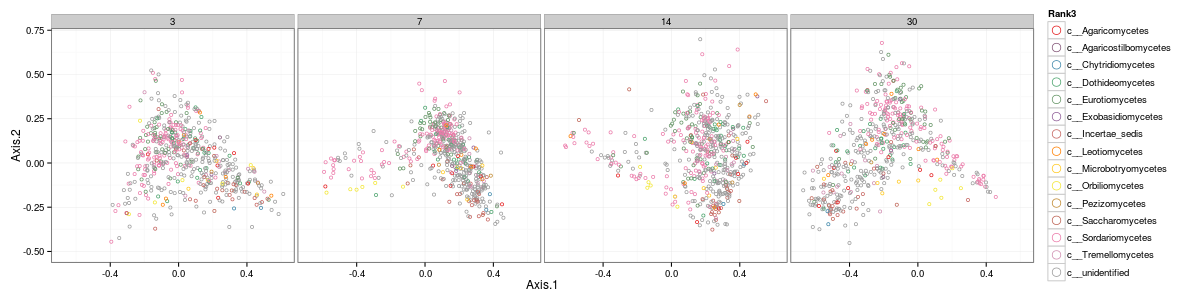

In [48]:
%%R -w 1200 -h 300

getPalette = colorRampPalette(brewer.pal(9, "Set1"))
#getPalette2= colorRampPalette(brewer.pal(8, "Dark2"))
#cmap1 = b2m.get_map("Set1", "qualitative", 9)
#cmap2 = b2m.get_map("Dark2", "qualitative", 7)
#cmap3 = b2m.get_map("Set2", "qualitative", 8)
#colors = c(getPalette,getPalette2)

p2 = ggplot(df.plot, aes(x = Axis.1, y = Axis.2, color = Rank3)) 

p2 = p2 + facet_grid(. ~ Day)

p2 = p2 + geom_point(alpha = 1, size = 1.5, shape = 21)

p2 = p2 + scale_color_manual(values=getPalette(15))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 4), label.position = "right"))

p2 = p2 + theme_bw()

p.otus = p2

p2

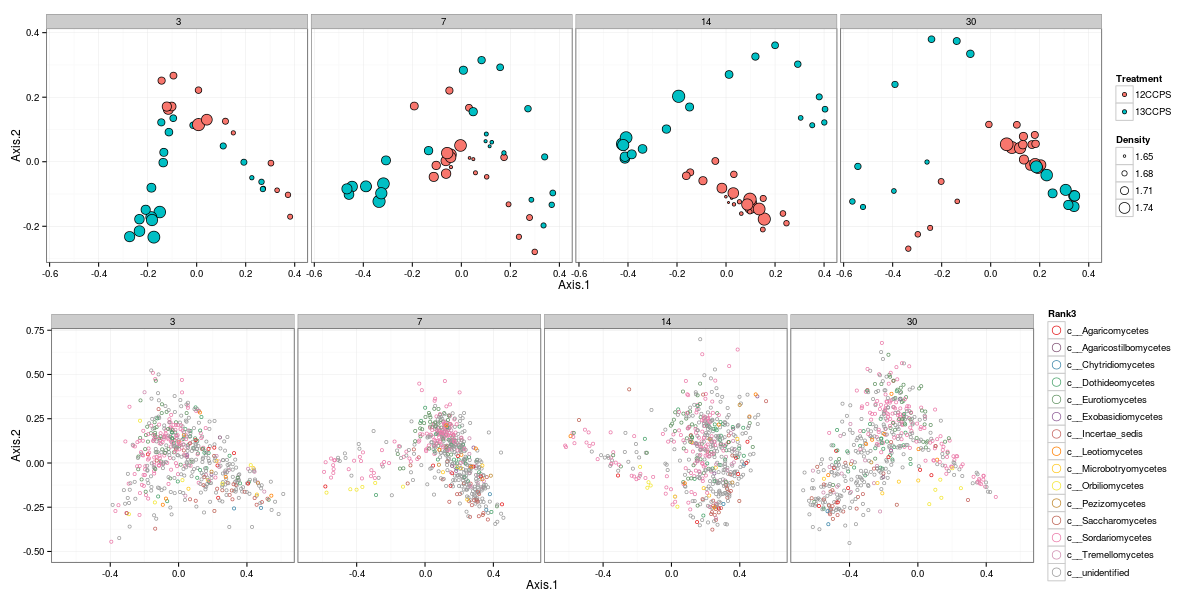

In [49]:
%%R -w 1200 -h 600

p.total = grid.arrange (p3, p2, ncol = 1, nrow = 2)


In [ ]:
%%R -w 1200 -h 800
pdf("data/figs/PCoA_by_day_OTUs.pdf", width = 14, height = 8)
grid.arrange(p3, p2, ncol=1, nrow=2)
dev.off()

In [ ]:
FileLink("data/figs/PCoA_by_day_OTUs.pdf")

Run 0 stress 0.08883458 
Run 1 stress 0.1074605 
Run 2 stress 0.1281283 
Run 3 stress 0.1074605 
Run 4 stress 0.08889257 
... procrustes: rmse 0.006956926  max resid 0.03299501 
Run 5 stress 0.08883458 
... New best solution
... procrustes: rmse 4.551744e-06  max resid 2.253358e-05 
*** Solution reached

Run 0 stress 0.06181737 
Run 1 stress 0.06040189 
... New best solution
... procrustes: rmse 0.0124586  max resid 0.05940062 
Run 2 stress 0.06040192 
... procrustes: rmse 3.636164e-05  max resid 7.447138e-05 
*** Solution reached

Run 0 stress 0.08167486 
Run 1 stress 0.1569595 
Run 2 stress 0.08166321 
... New best solution
... procrustes: rmse 0.001226489  max resid 0.005991652 
*** Solution reached

Run 0 stress 0.05866122 
Run 1 stress 0.05866121 
... New best solution
... procrustes: rmse 2.670302e-05  max resid 6.508822e-05 
*** Solution reached



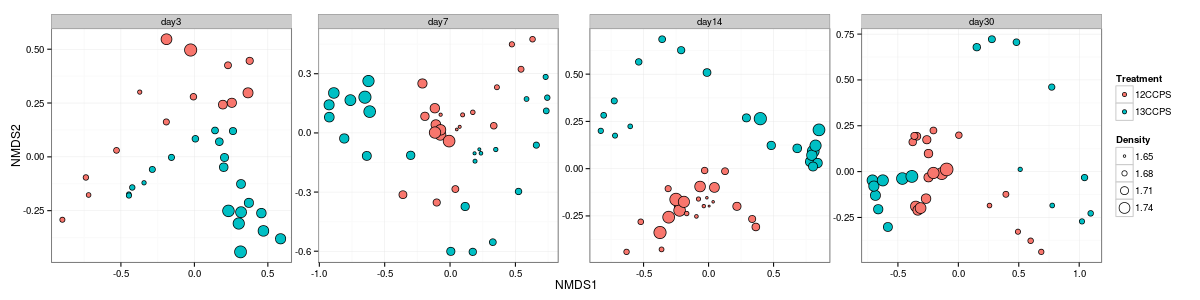

In [50]:
%%R -w 1200 -h 300

days = list(day3=3, day7=7, day14=14, day30=30)

md = sample_data(physeq.fungi.thresh)

ord = function(x) {
    ps = prune_samples((md$Day == x)&(md$SampleID != "D312.6"), physeq.fungi.thresh)
    pcoa = ordinate(ps, 
                method = "NMDS", 
                distance = "bray")
    p.pcoa = plot_ordination(ps, pcoa, justDF = TRUE)
    return(p.pcoa)
}

df = ldply(days, ord)

df$.id = factor(df$.id, levels= c("day3", "day7", "day14", "day30"))

#p = ggplot(df, aes(x = Density, y = Axis.1, size = Density, fill = Treatment))
p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p = p + facet_wrap(~.id, nrow = 1, scales = "free")

p = p + geom_point(shape = 21)

p = p + theme_bw()

p

In [51]:
%%R
d = subset(df, Day == 3)
d[order(-d$NMDS1),]

    .id        NMDS1        NMDS2 SampleID Primers       i2       i1 Day
12 day3  0.586645883 -0.380482413  D313.17     157 tcatcgag atagtacc   3
5  day3  0.469860069 -0.343845731  D313.16     156 ctgcgtgt atagtacc   3
19 day3  0.455978132 -0.261255983  D313.19     158 cgtgagtg atagtacc   3
32 day3  0.376385149  0.446152463  D312.17      57 atcgtacg cgagcgac   3
18 day3  0.371110221 -0.213587294  D313.20     159 ggatatct atagtacc   3
29 day3  0.365027956  0.297430308  D312.10      50 actatctg tagtctcc   3
8  day3  0.317774970 -0.256952050  D313.15     155 tagcgagt atagtacc   3
15 day3  0.317363288 -0.125922106  D313.21     160 gacaccgt atagtacc   3
10 day3  0.314231948 -0.441300588  D313.12     152 gacaccgt acgtgcgc   3
14 day3  0.301975693 -0.309482159  D313.14     154 actatctg atagtacc   3
21 day3  0.262721251  0.119899304  D313.25     164 ctgcgtgt gcgtatac   3
35 day3  0.254926961  0.251293798  D312.12      52 ctgcgtgt tagtctcc   3
4  day3  0.231887544 -0.250847179  D313.13     153 